In [1]:
import picamera
from threading import Thread
from queue import Queue, Empty
from time import time, sleep
import numpy as np
import cv2
import seaborn as sns
import imutils
import math
import pandas as pd

In [42]:
import io
from PIL import Image
import IPython

height = 272
width = 480

def imshow(a, fmt='jpeg', switch_RGB_BGR = False):
    '''
    Function to display an image within a Jupyter notebook.
    
    Use 'jpeg' instead of 'png' (~5 times faster)
    
    Keyword params:
    a -- numpy array to print; has width, height and no. of planes.
    fmt -- output format to print; 'jpeg' is the fastest.
    '''
    f = io.BytesIO()
    if switch_RGB_BGR is True:
        a = a[:,:,[2,1,0]]
    Image.fromarray(a).save(f, fmt)
    height = a.shape[0]
    width = a.shape[1]
    IPython.display.display(IPython.display.Image(data=f.getvalue(), width = width, height = height))
    
    
def writearray(array, filename):
    img = Image.fromarray(array, 'RGB')
    img.save(filename)
    
def readarray(filename):
    img = Image.open(filename)
    imarray = np.array(img)
    
    return imarray

In [27]:
img_red = readarray('gb_red.png')[:,:,[2,1,0]]
img_green = readarray('gb_green.png')[:,:,[2,1,0]]
img_blue = readarray('gb_blue.png')[:,:,[2,1,0]]

In [28]:
gray_r = cv2.cvtColor(img_red, cv2.COLOR_BGR2GRAY)
gray_b = cv2.cvtColor(img_green, cv2.COLOR_BGR2GRAY)
gray_g = cv2.cvtColor(img_blue, cv2.COLOR_BGR2GRAY)

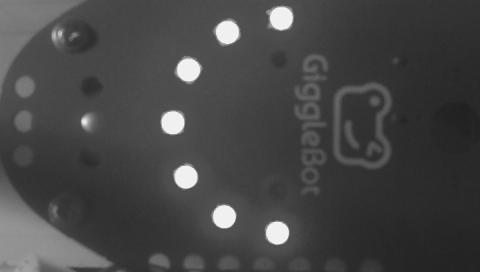

In [29]:
imshow(gray_r)

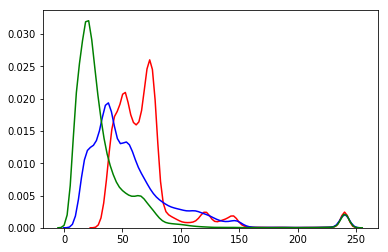

In [30]:
sns.distplot(gray_r.flatten(), hist = False, color = 'r')
sns.distplot(gray_b.flatten(), hist = False, color = 'b')
sns.distplot(gray_g.flatten(), hist = False, color = 'g')

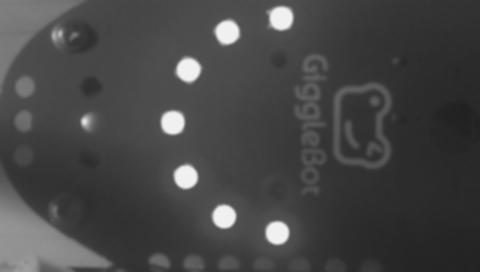

In [32]:
imshow(cv2.GaussianBlur(gray_r, (5,5), 0))

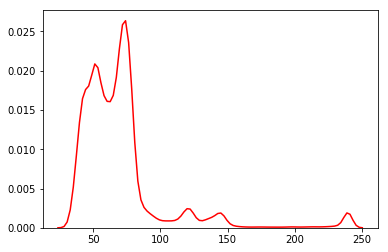

In [33]:
sns.distplot(cv2.GaussianBlur(gray_r, (5,5), 0).flatten(), hist = False, color = 'r')

In [152]:
blurred = cv2.GaussianBlur(gray_g, (5,5), 0)
thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

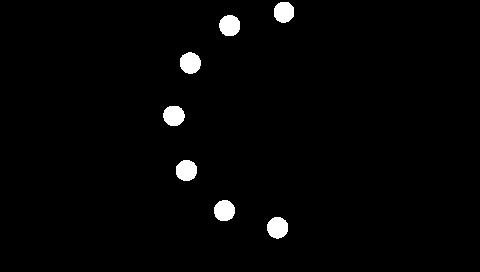

In [153]:
imshow(thresh[1])

In [154]:
contours = cv2.findContours(thresh[1].copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if imutils.is_cv2() else contours[1]

In [155]:
contour_list = []
radius = []
centers = []
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True, True)
    area = cv2.contourArea(contour)
    if ((len(approx)) > 8) and (len(approx) < 23) and area > 100:
        contour_list.append(contour)
        radius.append(perimeter / math.pi / 2)
        M = cv2.moments(contour)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        centers.append((cX, cY))

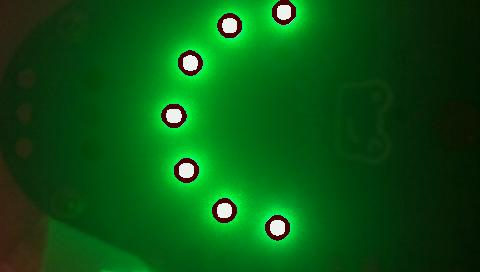

In [156]:
buf_img = img_green.copy()
cv2.drawContours(buf_img, contour_list, -1, (0, 0, 70), 3)
imshow(buf_img, switch_RGB_BGR=True)

In [157]:
scale = 1.7
intern_radius = np.mean(radius)
extern_radius = intern_radius * scale
intern_radius = math.ceil(intern_radius)
extern_radius = math.ceil(extern_radius)
extern_diam = extern_radius * 2

In [158]:
mask = np.zeros((height, width, 3), np.uint8)
for center in centers:
    cv2.circle(mask, center, extern_radius, (255, 255, 255), -1)
    cv2.circle(mask, center, intern_radius, (0, 0, 0), -1)

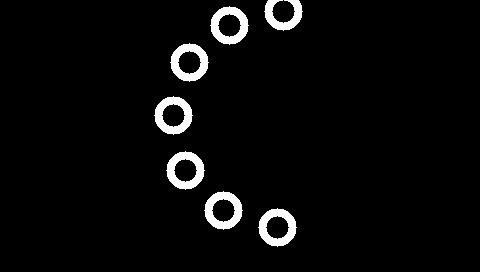

In [159]:
imshow(mask, switch_RGB_BGR=True)

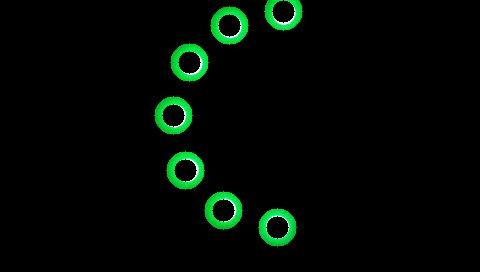

In [161]:
out = np.zeros((height, width, 3), np.uint8)
cv2.bitwise_and(img_green, mask, out)
imshow(out, switch_RGB_BGR=True)

In [162]:
hsv_img = cv2.cvtColor(out, cv2.COLOR_BGR2HSV)

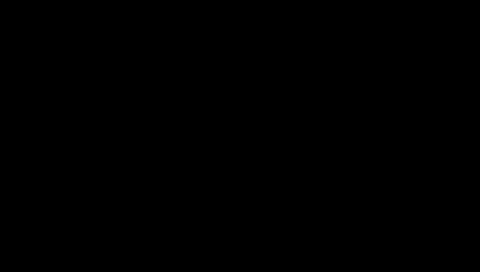

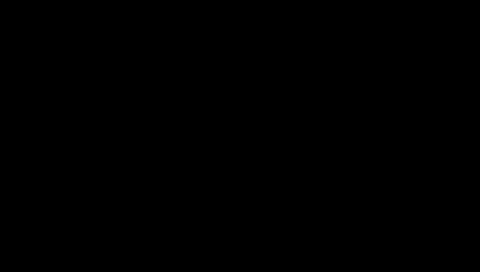

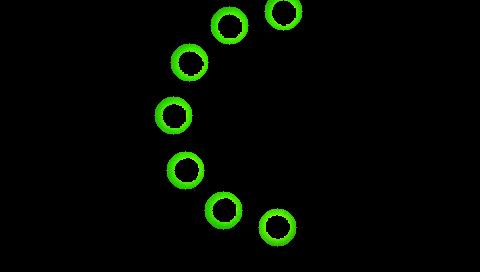

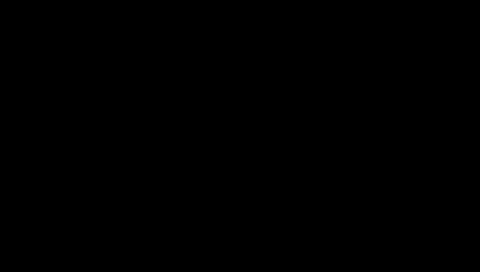

In [170]:
boundaries = [
	([0, 165, 128], [15, 255, 255]), # for red
    ([165, 165, 128], [180, 255, 255]), # for red
	([35, 165, 128], [75, 255, 255]), # for green
	([90, 165, 128], [133, 255, 255]) # for blue
]

for (lower, upper) in boundaries:
    lower = np.array(lower, dtype = np.uint8)
    upper = np.array(upper, dtype = np.uint8)
    
    mask = cv2.inRange(hsv_img, lower, upper)
    out2 = cv2.bitwise_and(out, out, mask = mask)
    print(out2)

In [251]:
a = out2.reshape((height * width, 3))
a[~np.all(a == 0, axis = 1)].shape[0]

1